# Fitting Saturation-based Simulation Data
In this notebook, we try to fit intensity data generated using a saturation based method. The mu_a for each of the maternal and fetal layer are based on a set oxygen saturation and HB concentration. The impact of all other pigments on mu_a are ignored. The goal for this experiment is to see if we can train a model to determine these hidden variables - the Hb conc. and the saturation just by looking at the intensity values!

# Instructions
I have the parameter search in one of the cells. Run eveerything above it to be able to run that cell.
If you don't want to search, ignore that cell and run everything above and below. 

# Issues
1. Only the mu_a's are changed, not any of the other properties! 
2. Fetal performance is not nearly as good as maternal. This could be due to the noise in the far ends of the plots. Maybe interpolation would help?
3. Fetal errors: Sat: ~3% Sat., Conc: ~1.9


# Notes
1. Using interpolated values seems to make the fitting more stable. Not better however.
2. Maternal is very good.
3. Fetal just estimates a mean!

# Things to Try
1. Fetal | Maternal = known

In [10]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, train_model_wtih_reporting
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models.custom_models import TwoChannelCNN, PerceptronReLU
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import os
import torchinfo
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [11]:
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity.pkl')
# data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc.pkl')
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/inverse_modelling_tfo/tools/s_based_intensity_low_conc.pkl')
equidistance_detector_normalization(data)

# Interpolate intensity to remove noise
data = interpolate_exp(data, weights=[1, -1])
data['Intensity'] = data['Interpolated Intensity']

# Manual log(intensity) normalization
data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log
data.head()

,SDD,Intensity,Wave Int,Uterus Thickness,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,Interpolated Intensity
0,10,-3.751989,1.0,5.0,6.0,0.12,0.9,0.11,0.1,1.770152e-04
1,14,-4.488716,1.0,5.0,6.0,0.12,0.9,0.11,0.1,3.245521e-05
2,19,-5.174669,1.0,5.0,6.0,0.12,0.9,0.11,0.1,6.688538e-06
3,23,-5.709445,1.0,5.0,6.0,0.12,0.9,0.11,0.1,1.952336e-06
4,28,-6.443955,1.0,5.0,6.0,0.12,0.9,0.11,0.1,3.597866e-07


In [12]:
data = pd.pivot(data, index=['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"], columns=["SDD", "Wave Int"], values="Intensity").reset_index()
data.dropna(inplace=True)   # Slight coding mistake, not all waveints have both wv1 and 2
data.head()

SDD,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10,14,19,23,28,...,55,59,64,68,73,77,82,86,91,95
Wave Int,,,,,,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
0,2.0,0.12,0.9,0.11,0.100,-3.856475,-4.649477,-5.319939,-5.795049,-6.411823,...,-11.373911,-11.804528,-12.334516,-12.753678,-13.273463,-13.687042,-14.202357,-14.613960,-15.128388,-15.540307
1,2.0,0.12,0.9,0.11,0.225,-3.855637,-4.646086,-5.311493,-5.780957,-6.388821,...,-11.450744,-11.895814,-12.445178,-12.880818,-13.422343,-13.854172,-14.393304,-14.824722,-15.364815,-15.797948
2,2.0,0.12,0.9,0.11,0.350,-3.854746,-4.642467,-5.302448,-5.765825,-6.364052,...,-11.525937,-11.985153,-12.553478,-13.005245,-13.568045,-14.017733,-14.580175,-15.030986,-15.596196,-16.050089
3,2.0,0.12,0.9,0.11,0.475,-3.853795,-4.638582,-5.292706,-5.749475,-6.337200,...,-11.599558,-12.072623,-12.659513,-13.127069,-13.710699,-14.177874,-14.763138,-15.232935,-15.822738,-16.296956
4,2.0,0.12,0.9,0.11,0.600,-3.852773,-4.634385,-5.282136,-5.731671,-6.307848,...,-11.671670,-12.158299,-12.763373,-13.246395,-13.850428,-14.334730,-14.942348,-15.430742,-16.044633,-16.538760


## Creating Features
x_columns will be the input features and y_columns are the target

In [13]:
# Rename multi-index columns
data.columns = ['_'.join([str(col[0]), str(col[1])]) if col[1] != '' else col[0] for col in data.columns]

# y_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]
y_columns = ['Maternal Saturation']
# y_columns = ['Fetal Saturation']
x_columns = list(filter(lambda X: '_' in X, data.columns))



## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])
## Manual scale - if needed (With maternal info.)
# data[x_columns[:-2]] /= 100.0    # stddev.   (Actual value is higher but let's keep it here for now)
# data[x_columns[:-2]] += 0.5  # unit var, 0 mean

## Scale non-intensity x columns (Maternal Hb Conc. , Maternal Saturation)
# data["Maternal Saturation"] -= 0.5 
# data["Maternal Hb Concentration"] /= 20
# data["Maternal Hb Concentration"] -= 0.5 


In [14]:
# Print Out Scaler values
print(f'Y scale mean {y_scaler.mean_}')
print(f'Y scale var {y_scaler.var_}')

Y scale mean [0.95]
Y scale var [0.00125]


In [15]:
data[y_columns].value_counts()

Maternal Saturation
-1.414214              375
-0.707107              375
 0.000000              375
 0.707107              375
 1.414214              375
dtype: int64

## Model Configuration

In [16]:
model_config = {
    'model_class' : TwoChannelCNN,  # Class name
    # 'model_class' : PerceptronReLU,  # Class name
    'model_params' :  [40, 4, 5, [2, 1]],    # Input params as an array
    # 'model_params' :  [[40, 8, 1]],    # Input params as an array
    # 'model_params' :  [[42, 8, 4, 1]],    # Input params as an array
    'train_split' : 0.8,
}

In [17]:
# Custom Train Function 
def train_model2(iteration_config, epoch=100):
    np.random.seed(70)  # Set seed for consistentcy
    params = {
        'batch_size': iteration_config['batch_size'], 'shuffle': True, 'num_workers': 2
    }
    train, val = generate_data_loaders(data, params, x_columns, y_columns, model_config['train_split'])
    # model = create_perceptron_model(config['model'])
    # model = create_perceptron_model([42, 8, 1])
    # model = TwoChannelCNN(40, 4, 5, [4, 1])
    model = model_config['model_class'](*model_config['model_params'])
    criterion = nn.MSELoss()
    optimizer = SGD(model.parameters(), lr=iteration_config["lr"], momentum=iteration_config["momentum"])
    # optimizer = Adam(model.parameters(), lr=config["lr"], betas=[config["b1"], config["b2"]])
    train_loss, val_loss = train_model_wtih_reporting(model, optimizer=optimizer, criterion=criterion, train_loader=train, validation_loader=val, epochs=epoch)

In [18]:
# Hyper Parameter Search 
iteration_config = {
    "lr" : tune.loguniform(1e-5, 1e-3),
    # "b1" : tune.uniform(0.3, 1.0),
    # "b2" : tune.uniform(0.3, 1.0),
    "batch_size": tune.choice([32, 16, 8]),
    # "model": tune.choice([[40, 5, 1], [40, 10, 1], [40, 5, 2, 1]]),
    "momentum": tune.choice([0.9, 0.95, 0.99]),
}
scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=50, grace_period=5, reduction_factor=2)
reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
result = tune.run(train_model2, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
                  num_samples=100, resources_per_trial={"cpu": 4, "gpu": 0.05},)

best_trial = result.get_best_trial("combined_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["val_loss"]))
print("Best trial final train loss: {}".format(
    best_trial.last_result["train_loss"]))


== Status ==
Current time: 2023-07-03 13:25:50 (running for 00:00:00.30)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 4.0/64 CPUs, 0.05/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-03_13-25-49
Number of trials: 70/100 (69 PENDING, 1 RUNNING)
+--------------------------+----------+-----------------------+--------------+-------------+------------+
| Trial name               | status   | loc                   |   batch_size |          lr |   momentum |
|--------------------------+----------+-----------------------+--------------+-------------+------------|
| train_model2_ccbf4_00000 | RUNNING  | 169.237.32.34:1276650 |            8 | 1.97535e-05 |       0.95 |
| train_model2_ccbf4_00001 | PENDING  |                       |           32 | 1.18892e-05 |       0.99 |
| train_model2_ccbf4_00002 | PENDING  |                       |         

Trial name,combined_loss,date,done,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,train_loss,training_iteration,trial_id,val_loss
train_model2_ccbf4_00000,2.02211,2023-07-03_13-25-54,False,blueberry,1,169.237.32.34,1276650,2.89902,2.89902,2.89902,1688415954,1.01157,1,ccbf4_00000,1.01054
train_model2_ccbf4_00001,2.93173,2023-07-03_13-25-57,False,blueberry,1,169.237.32.34,1276702,3.95867,3.95867,3.95867,1688415957,1.46363,1,ccbf4_00001,1.46811
train_model2_ccbf4_00003,2.10411,2023-07-03_13-25-58,False,blueberry,1,169.237.32.34,1276706,4.98152,4.98152,4.98152,1688415958,1.11466,1,ccbf4_00003,0.989454
train_model2_ccbf4_00004,2.35916,2023-07-03_13-25-57,False,blueberry,1,169.237.32.34,1276709,4.47285,4.47285,4.47285,1688415957,1.20829,1,ccbf4_00004,1.15087
train_model2_ccbf4_00006,2.34274,2023-07-03_13-25-57,False,blueberry,1,169.237.32.34,1276717,4.59033,4.59033,4.59033,1688415957,1.16863,1,ccbf4_00006,1.17411
train_model2_ccbf4_00007,2.0191,2023-07-03_13-25-57,False,blueberry,1,169.237.32.34,1276722,4.73047,4.73047,4.73047,1688415957,1.0156,1,ccbf4_00007,1.0035
train_model2_ccbf4_00009,2.0245,2023-07-03_13-25-57,False,blueberry,1,169.237.32.34,1276728,4.40505,4.40505,4.40505,1688415957,1.02699,1,ccbf4_00009,0.997508
train_model2_ccbf4_00012,2.85833,2023-07-03_13-25-58,False,blueberry,1,169.237.32.34,1276737,4.85714,4.85714,4.85714,1688415958,1.47152,1,ccbf4_00012,1.3868
train_model2_ccbf4_00013,2.291,2023-07-03_13-25-57,False,blueberry,1,169.237.32.34,1276741,4.31408,4.31408,4.31408,1688415957,1.1367,1,ccbf4_00013,1.1543
train_model2_ccbf4_00014,2.01352,2023-07-03_13-25-57,False,blueberry,1,169.237.32.34,1276743,4.52107,4.52107,4.52107,1688415957,1.01132,1,ccbf4_00014,1.0022


== Status ==
Current time: 2023-07-03 13:25:55 (running for 00:00:05.41)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 64.0/64 CPUs, 0.8000000000000002/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-03_13-25-49
Number of trials: 86/100 (70 PENDING, 16 RUNNING)
+--------------------------+----------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status   | loc                   |   batch_size |          lr |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+----------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------|
| train_model2_ccbf4_00000 | RUNNING  | 169.237.32.34:1276650

2023-07-03 13:28:06,832	INFO tune.py:945 -- Total run time: 136.99 seconds (136.96 seconds for the tuning loop).


== Status ==
Current time: 2023-07-03 13:28:06 (running for 00:02:16.96)
Using AsyncHyperBand: num_stopped=100
Bracket: Iter 40.000: -1.9759281700384532 | Iter 20.000: -1.9964107838294187 | Iter 10.000: -1.9993837742623708 | Iter 5.000: -2.010077068568967
Logical resource usage: 0/64 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-07-03_13-25-49
Number of trials: 100/100 (100 TERMINATED)
+--------------------------+------------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status     | loc                   |   batch_size |          lr |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+------------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------|
| train_model2_ccbf4_

<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [19]:
best_trial.config

{'lr': 7.700179252068976e-05, 'batch_size': 16, 'momentum': 0.99}

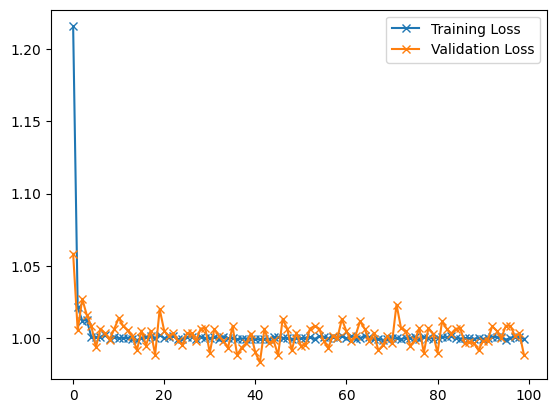

In [20]:
# Train Model with the given params.
np.random.seed(70)  # Set seed for consistentcy
params = {
    'batch_size': best_trial.config['batch_size'], 'shuffle': True, 'num_workers': 2
}
# params['batch_size'] = 32
train, val = generate_data_loaders(data, params, x_columns, y_columns, model_config['train_split'])
model = model_config['model_class'](*model_config['model_params'])
criterion = nn.MSELoss()
# criterion = nn.HuberLoss()
# optimizer = Adam(model.parameters(), lr=0.0009, betas=[0.935, 0.701])
# optimizer = SGD(model.parameters(), lr=0.00053, momentum=0.99)
optimizer = SGD(model.parameters(), lr=best_trial.config['lr'], momentum=best_trial.config['momentum'])
# CUDA_VISIBLE is already set to only see one GPU
train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=100, gpu_to_use=0)
plt.figure()
plt.plot(train_loss, label='Training Loss', marker='x')
plt.plot(validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

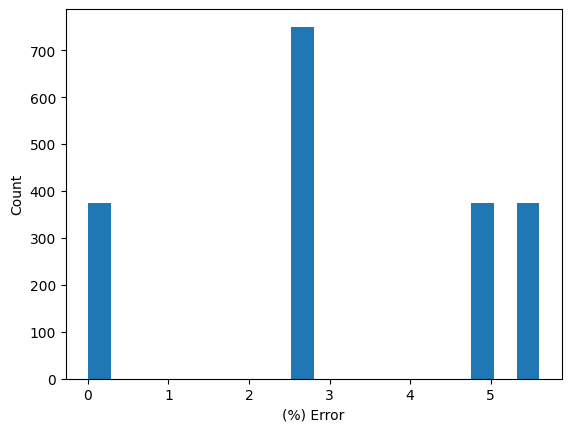

In [21]:
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[x_columns].values, dtype=torch.float).cuda()
    predictions = model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions).flatten()
    y_data = data[y_columns].to_numpy()
    y_data = y_scaler.inverse_transform(y_data).flatten()
    absolute_error = np.abs(y_data - predictions)
    error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error/y_data * 100})
plt.figure()
error_df['%tage'].plot.hist(bins=20)
plt.xlabel('(%) Error')
plt.ylabel('Count')
plt.show()

In [22]:
# Top Bad Samples
VIEW_TOP_N = 50
worst_errors = error_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]
combined_table = data.join(error_df)
with pd.option_context("display.max_rows", None):
    display(combined_table[['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation", 'Truth', 'Predicted', 'Absolute Error', '%tage']].iloc[worst_errors, :])

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,Truth,Predicted,Absolute Error,%tage
636,4.0,0.12,-1.414214,0.140,0.225,0.9,0.950404,0.050404,5.60041
1649,6.0,0.15,-1.414214,0.170,0.600,0.9,0.950404,0.050404,5.60041
758,4.0,0.13,-1.414214,0.125,0.475,0.9,0.950404,0.050404,5.60041
757,4.0,0.13,-1.414214,0.125,0.350,0.9,0.950404,0.050404,5.60041
756,4.0,0.13,-1.414214,0.125,0.225,0.9,0.950404,0.050404,5.60041
755,4.0,0.13,-1.414214,0.125,0.100,0.9,0.950404,0.050404,5.60041
754,4.0,0.13,-1.414214,0.110,0.600,0.9,0.950404,0.050404,5.60041
753,4.0,0.13,-1.414214,0.110,0.475,0.9,0.950404,0.050404,5.60041
752,4.0,0.13,-1.414214,0.110,0.350,0.9,0.950404,0.050404,5.60041
751,4.0,0.13,-1.414214,0.110,0.225,0.9,0.950404,0.050404,5.60041


In [23]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {validation_loss[-1] * y_scaler.var_ }')

Train Error(non-normalized): [0.00124968]
Validation Error(non-normalized): [0.00123519]


In [24]:
# Model Info
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
TwoChannelCNN                            --
├─Conv1d: 1-1                            24
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       130
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       3
│    └─Flatten: 2-4                      --
Total params: 157
Trainable params: 157
Non-trainable params: 0

In [25]:
error_df.columns

Index(['Truth', 'Predicted', 'Absolute Error', '%tage'], dtype='object')